# Higher dimensional Data

This is a continuation of the notebook "1d_new.ipynb". For the basics on how to use this package go through that paper.

Here we show a 2-D example for how the model works in higher dimensions. For this purpose we fit a 4th order polynomial in 2D.

## Creating the training data set

`jax.numpy` has almost the same usage as the standard `numpy` package, with the caveat that `jax.ndarray` is an immutable type, meaning that no inplace changes can be made. For creating training data this should however not be an issue.

In [23]:
import jax.numpy as jnp
from jax import random

We will model a forth order polynomial:

In [24]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]

    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval.

In [25]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
n_data = 100

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_data = random.uniform(subkey, (n_data,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02
key, subkey = random.split(key)
y_grad = grad(x_data, noise, subkey).reshape(-1)

We assume that we know the function value at $(0,0)$. The gradient is observed at random location inside the boundaries. 

For `Y_data` it is important that the gradient observations are ordered correctly. For example, if we have two gradient observations at the points $x$ and $x'$. then The order in `Y_data` must be ($\partial_{x_1} x, \partial_{x_2} x, \partial_{x'_1} x', \partial_{x'_2} x'$), i.e., all partial derivatives of the same point in order of the dimensions and one data point after another.

In [26]:
X_train = (jnp.zeros((1,1)), x_data)

Y_train = jnp.hstack((fun(X_train[0]), y_grad))

## Integration

In [27]:
from calcgp import FullIntegral
from calcgp.kernels import RBF

kernel = RBF()

model = FullIntegral(kernel, noise=noise)

model.train(X_train, Y_train)

True


In [28]:
predict_grid = jnp.array(jnp.meshgrid(jnp.linspace(*bounds, 101), jnp.linspace(*bounds, 101))).T.reshape(-1, 2)

# model.eval returns a mean prediction and a confidence interval around the mean prediction
means, stds = model.predict(predict_grid)

Text(0.5, 1.0, 'abs dif')

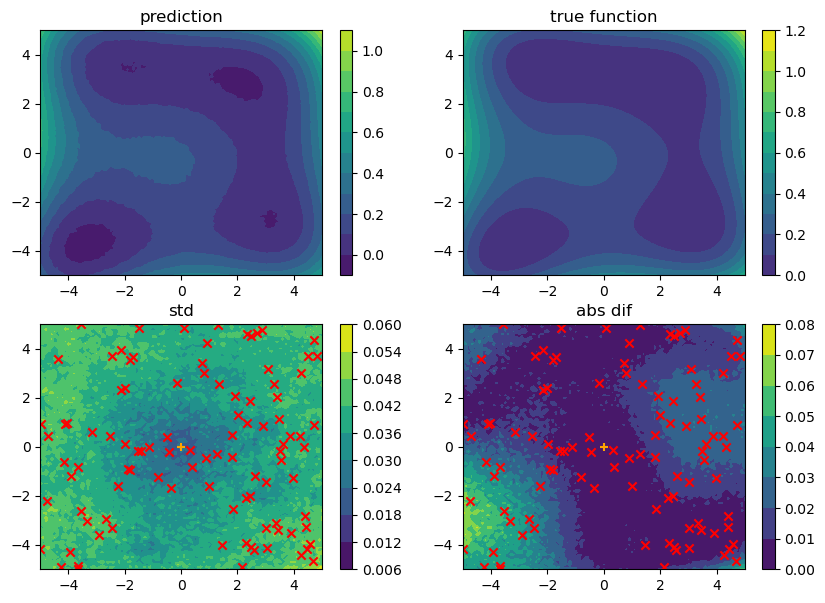

In [30]:
import matplotlib.pyplot as plt

means = means.reshape(101,101)
stds = stds.reshape(101,101)
true = fun(predict_grid).reshape(101,101)

fig, ax = plt.subplots(2, 2, figsize=(10,7))

mesh = jnp.meshgrid(jnp.linspace(*bounds, 101),jnp.linspace(*bounds, 101))

im1 = ax[0,0].contourf(*mesh, means, levels=12, vmin=-0.15, vmax=1.2)
im2 = ax[0,1].contourf(*mesh, true, levels=12, vmin=-0.15, vmax=1.2)
im3 = ax[1,0].contourf(*mesh, stds)
im4 = ax[1,1].contourf(*mesh, jnp.abs(means-true))
# im4 = ax[1,1].contourf(*mesh, jnp.greater(true, means-stds)*jnp.less(true, means+stds))

ax[1,1].scatter(x_data[:,0], x_data[:,1], c="r", marker="x", label="der pos")
ax[1,1].scatter(0,0, c="orange", marker="+", label="fun pos")

ax[1,0].scatter(x_data[:,0], x_data[:,1], c="r", marker="x", label="der pos")
ax[1,0].scatter(0,0, c="orange", marker="+", label="fun pos")

plt.colorbar(im1, ax=ax[0,0])
plt.colorbar(im2, ax=ax[0,1])
plt.colorbar(im3, ax=ax[1,0])
plt.colorbar(im4, ax=ax[1,1])

ax[0,0].set_title("prediction")
ax[0,1].set_title("true function")
ax[1,0].set_title("std")
ax[1,1].set_title("abs dif")